In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [8]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.3.0


In [9]:
tf.test.is_gpu_available()

True

In [10]:
keras = tf.keras
layers = tf.keras.layers

In [11]:
train_image_path = glob.glob('./dataset/dc/train/*/*.jpg')

In [12]:
len(train_image_path)

2000

In [13]:
train_image_path[-5:]

['./dataset/dc/train\\dog\\dog.995.jpg',
 './dataset/dc/train\\dog\\dog.996.jpg',
 './dataset/dc/train\\dog\\dog.997.jpg',
 './dataset/dc/train\\dog\\dog.998.jpg',
 './dataset/dc/train\\dog\\dog.999.jpg']

In [14]:
train_image_label = [int(p.split('\\')[1] == 'cat') for p in train_image_path]

In [15]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [16]:
train_image_label[ :5]

[1, 1, 1, 1, 1]

In [17]:
def load_preprosess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255
    return image, label

In [18]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [20]:
train_image_ds = train_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [21]:
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

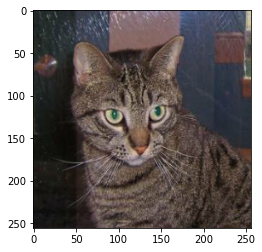

In [22]:
for img, label in train_image_ds.take(2):
    plt.imshow(img)

In [23]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [24]:
train_image_ds = train_image_ds.shuffle(train_count).repeat().batch(BATCH_SIZE)

In [25]:
test_image_path = glob.glob('./dataset/dc/test/*/*.jpg')
test_image_label = [int(p.split('\\')[1] == 'cat') for p in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_ds = test_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.repeat().batch(BATCH_SIZE)

In [26]:
test_count = len(test_image_path)
test_count

1000

keras内置经典网络实现

In [27]:
covn_base = tf.keras.applications.VGG16(weights='imagenet', 
                                        include_top=False)

## 冻结卷积基，训练分类层

In [28]:
covn_base.trainable = False

In [29]:
covn_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [30]:
model = keras.Sequential()
model.add(covn_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])

In [33]:
history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=3,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE)

Epoch 1/3
62/62 [==============================] - 73s 1s/step - loss: 0.5245 - acc: 0.7394 - val_loss: 0.4113 - val_acc: 0.8095
Epoch 2/3
62/62 [==============================] - 73s 1s/step - loss: 0.3436 - acc: 0.8543 - val_loss: 0.2858 - val_acc: 0.8831
Epoch 3/3
62/62 [==============================] - 73s 1s/step - loss: 0.2689 - acc: 0.8936 - val_loss: 0.2446 - val_acc: 0.9052


## 解冻卷积基，使部分层不可训练，不分层可训练，后期与已经训练好的分类层一起训练

In [34]:
covn_base.trainable = True

In [35]:
len(covn_base.layers)

19

In [36]:
fine_tune_at = -3

In [37]:
for layer in covn_base.layers[:fine_tune_at]:
    layer.trainable =  False

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0005/10),
              metrics=['accuracy'])

In [38]:
initial_epochs = 3      #先前已训练epoch
fine_tune_epochs = 2    #接着要训练的epoch
total_epochs =  initial_epochs + fine_tune_epochs


history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch = initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE)

Epoch 4/5
62/62 [==============================] - 70s 1s/step - loss: 0.2328 - acc: 0.9098 - val_loss: 0.2163 - val_acc: 0.9163
Epoch 5/5
62/62 [==============================] - 73s 1s/step - loss: 0.2059 - acc: 0.9229 - val_loss: 0.2068 - val_acc: 0.9224
